In [91]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from jax import random, vmap
import jax.numpy as jnp
from jax.scipy.special import logsumexp

import numpyro
from numpyro import handlers
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

[ 5.3191755  16.06104653 13.90251324  3.83470537 14.50614262 18.46539098
  6.43595486 14.40333215  5.0691641  17.48863129]
[ 7.47876325 23.59156979 20.35376986  5.25205805 21.25921393 27.19808647
  9.15393228 21.10499822  7.10374615 25.73294693]
[ 5.3191755  16.06104653 13.90251324  3.83470537 14.50614262 18.46539098
  6.43595486 14.40333215  5.0691641  17.48863129]
[ 7.47876325 23.59156979 20.35376986  5.25205805 21.25921393 27.19808647
  9.15393228 21.10499822  7.10374615 25.73294693]


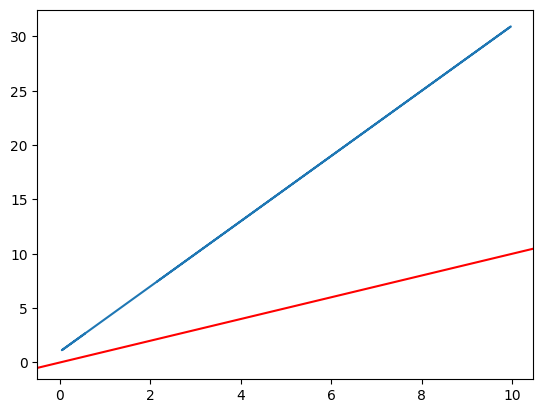

In [92]:
# Load data file
dset = pd.read_csv("data/simple_dag.csv", sep=",")

def standardize(x):
    return (x-x.mean(0)) / x.std(0)

def normalize(x):
    print(x.max(0), x.min(0))
    return (x-x.min(0)) / (x.max(0)-x.min(0))

y = dset["C"].values
X = dset[["A", "B"]].values

print(X[:, 1][:10])
print(y[:10])

vars = [
    "A",
    "B",
    "C",
]
# sns.pairplot(dset, x_vars=vars, y_vars=vars, palette="husl")
# plt.show()

# X = standardize(X)
# y = standardize(y)
p_star = 1

# plt.plot(X[:, 0], y)
plt.axline((0, 0), (1, 1), color='r')

plt.plot(X[:, 0], y)
print(X[:, 1][:10])
print(y[:10])


In [93]:
def model(X, y=None):

    b = numpyro.sample("b", dist.Normal(1, 0.5).expand([X.shape[1]]))
    sigma = numpyro.sample("sigma", dist.Normal(0, 1))
    a = numpyro.sample("a", dist.Normal(1, 1).expand([X.shape[0]]))

    mu = a + jnp.dot(X, b)
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)

def hs_model(X, y=None, sigma=1):
        '''
        Parameters:
           array y: dependent variable
           int sigma: stdev of y
        '''
        N, D = X.shape
        t0_lambdas = numpyro.sample("lambdas", dist.HalfCauchy(jnp.ones(D)))
        t0_tau = (p_star / (D-p_star)) * sigma
        
        # slightly different parametrization for efficiency
        t0_unscaled_betas = numpyro.sample("unscaled_betas", dist.Normal(0, jnp.ones(D)))
        t0_scaled_betas = numpyro.deterministic("betas", t0_tau*t0_lambdas*t0_unscaled_betas)

        # intercept
        a = numpyro.sample("a", dist.Normal(1, 1).expand([X.shape[0]]))

        kappas = numpyro.deterministic("kappas", 1 / (1 + N * t0_tau**2 * t0_lambdas**2))
        y_mean = numpyro.deterministic("y_mean", a + jnp.dot(X, t0_scaled_betas))

        numpyro.sample('y', dist.Normal(y_mean, sigma), obs=y)

In [94]:
rng_key = random.PRNGKey(0)
nuts = NUTS(hs_model)
mcmc = MCMC(nuts, num_warmup = 500, num_samples=1000, num_chains=4)
mcmc.run(
    rng_key, 
    X=X,
    y=y
)
mcmc.print_summary()

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_74230/2748893297.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup = 500, num_samples=1000, num_chains=4)
sample: 100%|██████████| 1500/1500 [00:04<00:00, 317.88it/s, 1023 steps of size 4.67e-03. acc. prob=0.83]



                       mean       std    median      5.0%     95.0%     n_eff     r_hat
             a[0]      1.02      0.74      1.00     -0.24      2.19    350.36      1.01
             a[1]      1.01      0.70      1.03     -0.17      2.15   2473.51      1.00
             a[2]      1.02      0.69      1.02     -0.12      2.15   2437.74      1.00
             a[3]      1.00      0.71      0.99     -0.23      2.12   2382.54      1.00
             a[4]      1.01      0.70      1.01     -0.15      2.14   1936.56      1.00
             a[5]      1.01      0.71      1.02     -0.20      2.12   2616.44      1.00
             a[6]      0.97      0.71      0.98     -0.16      2.16   1068.79      1.01
             a[7]      1.01      0.70      1.02     -0.14      2.16   2654.92      1.00
             a[8]      0.98      0.71      0.96     -0.10      2.19   2299.09      1.00
             a[9]      1.01      0.73      1.03     -0.12      2.33   2141.65      1.00
            a[10]      1.00    

In [95]:
samples = mcmc.get_samples()

In [98]:
betas = samples["betas"]
mean_betas = betas.mean(0)
print(mean_betas)

a = samples["a"]
print(a.mean())

[2.976709   0.01091824]
0.9974237


In [ ]:
samples_1 = mcmc.get_samples()
predictive = Predictive(hs_model, samples_1)
predictions = predictive(random.PRNGKey(0), 
                         X=X,
                         y=y)['y']
predictions


In [ ]:
mean_pred = predictions.mean(axis=0)
plt.plot(range(len(mean_pred)), mean_pred, 'b.')
plt.plot(range(len(y)), y, 'r.')
plt.show()

NameError: name 'predictions' is not defined

In [ ]:
mean_betas = samples_1['betas'].mean(0)
print(sum((jnp.dot(X, mean_betas)) - y))


[ 1.7881393e-07 -1.3369322e-04  9.0950727e-04 -3.6239624e-05
 -2.5928020e-06  2.6598573e-06 -1.3369322e-04 -1.0752678e-04
  1.7881393e-07 -1.0061264e-04 -3.3438206e-04 -2.2673607e-04
 -8.7541342e-04  2.3317337e-04  3.4469366e-04  2.6598573e-06
  9.0950727e-04 -1.3369322e-04 -1.0752678e-04 -4.1842461e-05
 -1.3369322e-04  2.3317337e-04 -3.6239624e-05  2.3317337e-04
  2.3317337e-04 -4.1842461e-05 -8.7541342e-04  3.4469366e-04
 -1.0061264e-04 -2.5928020e-06 -1.0752678e-04 -4.1842461e-05
 -1.0061264e-04 -8.7541342e-04 -4.1842461e-05  2.3317337e-04
 -8.7541342e-04 -3.3438206e-04 -8.7541342e-04  2.3317337e-04
  1.7881393e-07  3.4469366e-04  9.0950727e-04 -1.0061264e-04
 -1.0061264e-04  2.6598573e-06 -8.7541342e-04 -8.7541342e-04
 -3.3438206e-04 -8.7541342e-04  9.0950727e-04  3.4469366e-04
 -2.2673607e-04 -1.0061264e-04  2.6598573e-06 -2.5928020e-06
 -1.0061264e-04 -2.5928020e-06  3.4469366e-04  2.6598573e-06
 -2.2673607e-04 -1.3369322e-04  3.4469366e-04  9.0950727e-04
  2.3317337e-04  3.44693